**Created by Sanskar Hasija**

**[JAX+FLAX+TF.DATA] Vision Transformers Tutorial 🚀**

**19 February 2021**


# <center> [JAX+FLAX+TF.DATA] VISION TRANSFORMERS TUTORIAL 🚀  </center>
## <center>If you find this notebook useful, support with an upvote👍</center>

# Table of Contents
<a id="toc"></a>
[1. Introduction  ](#1)<br>
[2. Installations](#2)<br>
[3. TPU SETUP](#3)<br>
[4. TF.data Pipeline](#4)<br>
[5. Image Augumentations](#5)<br>
[6. Pre-Processing Data for modelling  ](#6)<br>
[7. Model Define and Configuration ](#7)<br>
[8. Model Training ](#8)<br>
[9. Evaluating Predictions ](#9)<br>
[10. Test Predictions and Submission ](#10)<br>

<a id="1"></a>
# **<center><span style="color:#00BFC4;">Introduction </span></center>**

## <span style="color:#e76f51;"> Notebook overview : </span>
* This notebook is end to end notebook for Petals to the Metal - Flower Classification using state of the art ViT (Vision Transformer) architechure.<br>
* The ViT model is an transformer based arcitecture for image classification task.The ViT model was intorduced in the research paper [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf). 
* Pre-trained on imagenet dataset, the ViT model is fine tuned on the dataset in JAX and Flax.Input dataset piplines for training, validaiton and inference(submission) are built using tf.data api 

   
<h2> <span style="color:#e76f51;"> JAX : </span></h2> 
<center><img src="https://jax.readthedocs.io/en/latest/_static/jax_logo_250px.png" width="250" height="200" /></center><br>



* JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research. JAX can automatically differentiate native Python and NumPy code.<br>
* JAX uses XLA to compile and run your NumPy code on accelerators, like GPUs and TPUs. Compilation happens under the hood by default, with library calls getting just-in-time compiled and executed. JAX even lets  just-in-time (JIT)  compile  Python functions into XLA-optimized kernels using a one-function API.<br> 
* Compilation and automatic differentiation can be composed arbitrarily, to get maximal performance without having to leave Python.<br>

Check out Flax documentation - [here](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html).<br>
    

    
<h2> <span style="color:#e76f51;">Flax : </span></h2> 
<center><img src="https://flax.readthedocs.io/en/latest/_static/flax.png" width="250" height="200" /></center><br>



* Flax is a high-performance neural network library for JAX that is designed for flexibility. <br>
* Flax was originally started by engineers and researchers within the Brain Team in Google Research (in close collaboration with the JAX team), and is now developed jointly with the open source community.<br>

Check out Flax documentation - [here](https://flax.readthedocs.io/en/latest/overview.html#flax).<br>
    
    


    
<h2> <span style="color:#e76f51;">TF.data </span></h2> 
<center><img src="https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data.png" width="800" height="200" /></center><br>



* TF.DATA API is used for building efficient input pipelines which can handle large amounts of data and perform complex data transformations. <br>
* TF.DATA API has provisions for handling different data formats.<br>

Check out tf.data guide and  documentation - [here](https://www.tensorflow.org/guide/data).<br>



<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Installations</span></center> 
<a id="2"></a>

* ViT official repository by Google-Research is cloned and appended in the system path. Check out the GitHub repo - [here](https://github.com/google-research/vision_transformer).

In [5]:
from IPython.display import clear_output

![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

!pip install clu==0.0.2
!pip install einops

!pip3 install -U jaxlib        # Updating to latest versioln of jaxlib
!pip3 install -U jax           # Updating to latest versioln of jax
!pip3 install -U flax          # Updating to latest versioln of flax
clear_output()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> TPU Setup </span></center> 
<a id="3"></a>

## <span style="color:#e76f51;">Setting up TPU for JAX : </span>

* This notebook works with all three accelerator <b><u>TPU, GPU and CPU</u></b> provided by Kaggle.But using TPU is recommended for faster training and evaluation.

In [6]:
import os
if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print("TPU DETECTED!")
    print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
    print('No TPU detected.')
import jax   
DEVICE_COUNT = len(jax.local_devices())
TPU = DEVICE_COUNT==8

if TPU:
    print("")
    print("8 cores of TPU ( Local devices in Jax ):")
    print('\n'.join(map(str,jax.local_devices())))

No TPU detected.


## <span style="color:#e76f51;"> Imports : </span>


In [7]:
import sys
sys.path.append('./vision_transformer')

#VISION TRANSFORMER REPO IMPORTS 
from vit_jax import utils
from vit_jax import train
from vit_jax import models
from vit_jax import checkpoint
from vit_jax import momentum_clip
from vit_jax import input_pipeline
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

#LIBRARIES IMPORT 
import os
import re 
import jax
import flax
import math
import tqdm
import warnings
import numpy as np
import pandas as pd
import jax.numpy as jnp
from scipy import stats
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# **<center><span style="color:#00BFC4;"> TF.data Pipeline </span></center>**
<a id="4"></a>


<center><img src="https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data-simple-pipeline.png" width="800" height="300" />


📌 tf.data API is used for building efficient input pipelines which can handle large amounts of data and perform complex data transformations . tf.data API has provisions for handling different data formats.
    
📌The tf.data API enables you to build complex input pipelines from simple, reusable pieces. The tf.data API also makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

📌The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

**Input Pipeline :**

* tf.data.TFRecordDataset() is used to create an input pipeline for data stored in TFRecord format .
 


**Transformations :**

* The Dataset object can be transformed into a new Dataset by chaining method calls on the tf.data.Dataset object . Some of the transformations which can be applied are Dataset.map() , Dataset.batch() , Dataset.shuffle() , Dataset.prefetch() .

* The Dataset object is a Python iterable which  it possible to consume its elements using a for loop .

<center><img src="https://drive.google.com/uc?id=1x383ghyybTV0jQqBSlHDEc8FWD8AqaHz" width="550" height="500" /></center>

## <span style="color:#e76f51;"> Setting up TF.data Pipeline  : </span>

In [8]:
IMAGE_SIZE = [512,512]
if TPU :
    from kaggle_datasets import KaggleDatasets
    GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
    GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-'+ str(IMAGE_SIZE[0])+"x" + str(IMAGE_SIZE[1])
    PATH = GCS_PATH 
    
else: 
    PATH = "../input/tpu-getting-started/tfrecords-jpeg-"+ str(IMAGE_SIZE[0])+"x" + str(IMAGE_SIZE[1])

The data is provided serialized into TFRecords. This is a format convenient for distributing data to each of the TPUs cores. 
The tf.data input pipeline used in this notebook is a modified version of the wonderful beginner notebook - [Create Your First Submission](https://www.kaggle.com/ryanholbrook/create-your-first-submission)
of the [Computer Vision](https://www.kaggle.com/learn/computer-vision) course provided by Kaggle.

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
SEED = 12 
TRAINING_FILENAMES = tf.io.gfile.glob(PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(PATH + '/test/*.tfrec') 


CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


# function for decoding and reshaping image
def decode_image(image_data):                             
    """
    Decodes jpeg image and reshapes 
    it to (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)   
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    return image


# function for reading labeled tf_record
# useful for loading train and valid data
def read_labeled_tfrecord(example):                       
    """
    Reads labeled tf_record for train/valid
    datasets
    """
    LABELED_TFREC_FORMAT = {                             
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64),  
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label 


# function for reading un_labeled tf_record
# useful for loading test data 
def read_unlabeled_tfrecord(example):                     
    """
    Reads unlabeled tf_record for 
    test dataset
    """
    UNLABELED_TFREC_FORMAT = {                            
        "image": tf.io.FixedLenFeature([], tf.string), 
        "id": tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum 


#function to load datasets
def load_dataset(filenames, labeled=True,ordered = False ): 
    """
    Loads tf.data.Dataset 
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

# function for counting total items
def count_data_items(filenames):                           
    """
    Counts the number of 
    data items
    """
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

Now Datasets are loaded and then mapped to a function that names the respective tensor for further processing.

In [10]:
train_ds = load_dataset(TRAINING_FILENAMES, labeled=True)
valid_ds = load_dataset(VALIDATION_FILENAMES, labeled=True )
test_ds =  load_dataset(TEST_FILENAMES, labeled=False, ordered=True)

# function for renaming
def idx_name(image,label):                           
    return dict( image =image ,
               label = label)

# function for renaming
def idx_name_test(image, image_id):                  
    return dict(image = image,
               image_id= image_id)


train_ds = train_ds.map(idx_name,num_parallel_calls=AUTO)
valid_ds = valid_ds.map(idx_name,num_parallel_calls=AUTO)
test_ds = test_ds.map(idx_name_test,num_parallel_calls=AUTO)

2022-02-19 21:20:52.591134: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-19 21:20:52.591202: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)


<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# **<center><span style="color:#00BFC4;">Image Augumentations </span></center>**
<a id="5"></a>

## <span style="color:#e76f51;"> Visualizing Differnt Augumentations  : </span>


<b> Data augmentation is a technique through which one can increase the size of the data for the training of the model without adding the new data.<br> Techniques like padding, cropping, rotating, and flipping are the most common methods that are used over the images to increase the data size. </b><br>
<br>
There are six different augumentations/transformations implemented in this notebook :<br>
* Random Brighness<br>
* Random Contrast <br>
* Random Saturation<br>
* Random Crop or Pad<br>
* Random Rotate<br>
* Sharpness<br>


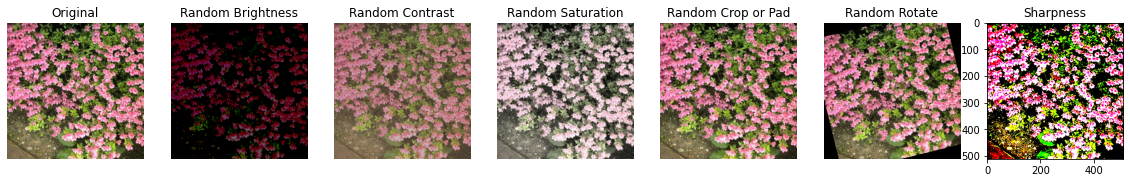

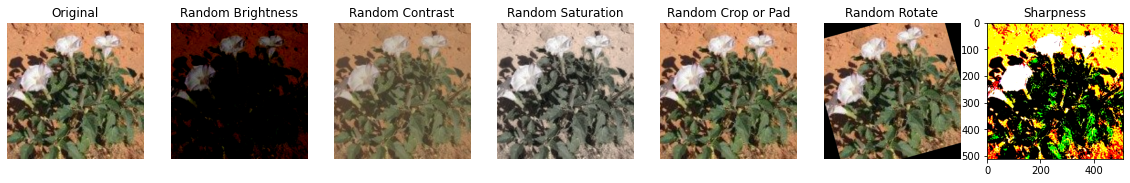

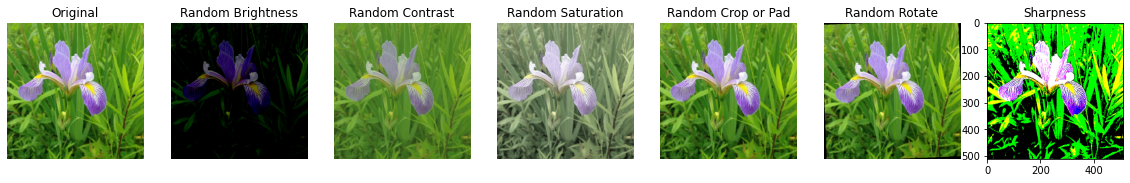

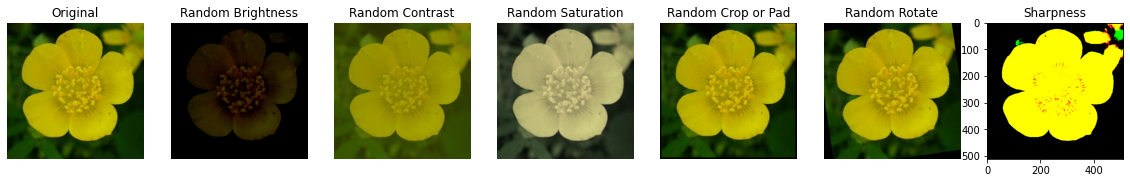

In [11]:
VIS_IMAGE = 4
aug_batch = next(iter(train_ds.batch(VIS_IMAGE).as_numpy_iterator()))
for image in aug_batch["image"]: 
    seed = (SEED, SEED)
    image = image/ 255
    random_bright = tf.image.stateless_random_brightness(image, max_delta=1.0, 
                                                       seed = seed)
    random_contrast = tf.image.stateless_random_contrast(image, 0.2, 2.0,
                                                       seed = seed)
    random_saturation = tf.image.stateless_random_saturation(image, 0.2, 1.0,
                                                           seed = seed)
    random = tf.random.uniform(shape=[],minval=-20, maxval=20).numpy().astype("int")
    random_crop_or_pad = tf.image.resize_with_crop_or_pad(image, 
                               tf.shape(image).numpy()[0] + random, 
                               tf.shape(image).numpy()[1] + random)
    random_rotate = tfa.image.rotate(image, tf.constant(tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.4)))
    sharpness = tfa.image.sharpness(image, 5.1)

    plt.figure(figsize = (20, 20))
    
    plt.subplot(1, 7, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original')
    
    plt.subplot(1, 7, 2)
    plt.imshow(random_bright.numpy())
    plt.title('Random Brightness')
    plt.axis('off')
    
    plt.subplot(1, 7, 3)
    plt.imshow(random_contrast.numpy())
    plt.title('Random Contrast')
    plt.axis('off')
    
    plt.subplot(1, 7, 4)
    plt.imshow(random_saturation.numpy())
    plt.title('Random Saturation')
    plt.axis('off')
    
    plt.subplot(1, 7, 5)
    plt.imshow(random_crop_or_pad.numpy())
    plt.title('Random Crop or Pad')
    plt.axis('off')
    
    plt.subplot(1, 7, 6)
    plt.imshow(random_rotate.numpy())
    plt.title('Random Rotate')
    plt.axis('off')
    
    plt.subplot(1, 7, 7)
    plt.imshow(sharpness.numpy())
    plt.title('Sharpness')

#### Difference between normal tf.image functions and stateless ones:
* There are two sets of random image operations: `tf.image.random*` and `tf.image.stateless_random*`. 

* Using `tf.image.random*` operations is strongly discouraged as they use the old RNGs from TF 1.x. (TensorFlow Website)

## <span style="color:#e76f51;"> Defining Augumentation function for preprocess   : </span>

* Transformations are divided into `two groups` with a 50% chance of being applied.
* The two groups are further divided into `two sub-groups` with an equal chance of being applied.
* Each of the `four sub-groups` transformations have a  25% chance of being applied 

In [13]:
def aug(data):
    """
    Augument the image with one of four 
    different equal likely transformations.
    Transformations:
    1. Random Contrast
    2. Random Brightness
    3. Random Saturation
    4. Random Rotation
    """
    image = data["image"]
    seed = (SEED,SEED)
    
    # two groups for transformations
    transformation_selection = tf.random.uniform([], minval = 0, 
                                                 maxval = 1, 
                                                 dtype = tf.float32)
    
    # probability for sub groups
    # each transformation has 25% chance
    # of being applied on image
    prob_1 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)  
    prob_2 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)
    image = tf.cond(tf.greater(transformation_selection, 0.5),
                    lambda: tf.cond(tf.greater(prob_1, 0.5),
                            lambda: tf.image.stateless_random_contrast(image, 0.1, 0.5,
                                                     seed = seed), 
                            lambda: tf.image.stateless_random_brightness(image, max_delta=0.3, 
                                                     seed = seed),
                           ),
                    lambda: tf.cond(tf.greater(prob_2, 0.5),
                            lambda: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                                           seed = seed),
                            lambda: tfa.image.rotate(image, tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.2))                          
                          )     
                   )
    data["image"] = image
    return data

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# **<center><span style="color:#00BFC4;">Pre-Processing Data for modelling  </span></center>**
<a id="6"></a>

## <span style="color:#e76f51;"> Loading Train and Validation dataset   : </span>

* The `input_pipline` moduled imported earlier helps us in setting the innput_data pipline.
* The `train_ds` and `valid_ds` datasets are instantiated using the `get_data` function from `input_pipline` module <br>
<br>
* The arguments of get_data function are as follows: 
    * data: tf.dataset to read data from
    * mode: train or test. `test for evaluation(validation) task`
    * num_classes : Number of output classes (All classes get one-hot encoded) 
    * image_decoder : image_decoder function if image is not decoded before passing to the function
    * repeats : Number of time dataset to be repeated
    * batch_size : Batch Size
    * image_size : Image size after cropping (for training) / resizing (for
    evaluation).
    * shuffle_buffer : Buffer size for shuffling dataset
    * preproces : Optional preprocessing for data
    

The dataset passed on to the `get_data` function gets augumented according to the preproces function passed, and then processed as required by the model and get reshaped as:<br>
#### <center><span style="color:#e76f51;"> <b>(IMAGE HEIGHT, IMAGE WIDTH , 3)</b> --><b>(DEVICE COUNT, BATCH, IMAGE HEIGHT, IMAGE WIDTH , 3)</b> </span></center>

* In case of `TPU - DEVICE COUNT = 8`, and in `GPU and CPU DEVICE COUNT = 1`.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = 102
SHUFFLE = 1024
IMAGE_DECODER = lambda image : image
BATCH_SIZE = 16 *  DEVICE_COUNT
IMAGE_SIZE = 512
PREPROCESS = aug

train_ds = input_pipeline.get_data(
    data = train_ds,
    mode = "train",
    num_classes = NUM_CLASSES,
    image_decoder = IMAGE_DECODER,
    repeats = None,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle_buffer = SHUFFLE,
    preprocess = PREPROCESS
    )

# No augumentation required for validation_dataset
valid_ds = input_pipeline.get_data(
    data = valid_ds,
    mode = "test",
    num_classes = NUM_CLASSES,
    image_decoder = IMAGE_DECODER,
    repeats = 1,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle_buffer = SHUFFLE,
    preprocess = None                         
    )

## <span style="color:#e76f51;"> Loading Test dataset   : </span>

* Unfortunately get_data function from input_pipline does not generate data from inference data without any labels.
* `test_ds` have been manually processed and `shared across the 8 devices of TPU` (if present)

    
* Images in test_ds are first normalized, then batched together in batch_size defined before.<br>
* After batching the shape changes as :<br>
<h4> <center><span style="color:#e76f51;"> <b>(IMAGE HEIGHT, IMAGE WIDTH , 3)</b> --><b>(BATCH, IMAGE HEIGHT, IMAGE WIDTH , 3)</b> </span></center></h4>
    * Then batched_images are shared across <b><u>8 TPU cores</u></b> (if present). The shape changes as :<br>
<h4><center><span style="color:#e76f51;"> <b>(BATCH, IMAGE HEIGHT, IMAGE WIDTH , 3)</b> --><b>(DEVICE COUNT, BATCH, IMAGE HEIGHT, IMAGE WIDTH , 3)</b></span></center> </h4><br>


In [15]:
# Extracting test ids for submission later
test_ids_ds = test_ds.map(lambda data : data["image_id"])
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') 


#Reshaping data to devices 
#(8 in case of TPU and 1
# in case of GPU and CPU)
def shared_data(data):
    """
    Reshapes image from (BATCH, IMAGE HEIGHT, IMAGE WIDTH , 3) to 
    (DEVICE COUNT, BATCH, IMAGE HEIGHT, IMAGE WIDTH , 3) 
    """
    data = tf.reshape(data,shape = [DEVICE_COUNT, -1, IMAGE_SIZE, IMAGE_SIZE, 3]) 
    return data   

                                                                                  
def normalize(image):
    """
    Normalized an image tensor
    """
    image = (image - 127.5) / 127.5
    return image

def test_data_prep(dataset):  
    """
    Prepares test data for inference 
    similar to get_data 
    function of input_pipeline
    """
    dataset = dataset.map(lambda data: data["image"])
    dataset = dataset.map(normalize)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)               
    dataset = dataset.map(shared_data, tf.data.experimental.AUTOTUNE)
    return dataset.prefetch(1)
test_ds = test_data_prep(test_ds)

## <span style="color:#e76f51;"> Visualizing Processed Training Images : </span>

In [16]:
def show_image_grid(images, labels ):
    """
    Create a plot of 32 images
    """
    rows = 4
    cols = 8
    fig = plt.figure(figsize=(20,11))
    for i in range(1, cols*rows+1 ):
        img = images[i-1]
        img = (img +1) / 2 
        fig.add_subplot(rows, cols, i)
        plt.axis('off')
        plt.title(CLASSES[labels[i-1]], fontsize=14)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

In [17]:
# You need to change this code if you change batch_size
train_batch = next(iter(train_ds))
images = np.append(
    train_batch['image'][0].numpy(), 
    train_batch['image'][1].numpy(), 
    axis = 0)
labels = np.append(
    train_batch['label'][0].numpy().argmax(axis = 1), 
    train_batch['label'][0].numpy().argmax(axis = 1))
show_image_grid(images, labels)

2022-02-19 21:23:57.451548: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at strided_slice_op.cc:108 : Invalid argument: slice index 1 of dimension 0 out of bounds.


InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

## <span style="color:#e76f51;"> Visualizing Validation Images   : </span>

In [ ]:
# You need to change this code if you change batch_size
valid_batch = next(iter(valid_ds))
images = np.append(
    valid_batch['image'][0].numpy(), 
    valid_batch['image'][1].numpy(), 
    axis = 0)
labels = np.append(
    valid_batch['label'][0].numpy().argmax(axis = 1) , 
    valid_batch['label'][0].numpy().argmax(axis = 1))
show_image_grid(images, labels)

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="7"></a>
# **<center><span style="color:#00BFC4;">Model Define and Configuration  </span></center>**

## <span style="color:#e76f51;"> Vision Transformer Architecture : </span>

<center><img src="https://miro.medium.com/max/975/1*-DBSfgxHUuknIqmyDVKwCg.png" width="850" height="800" /></center>

* Transformers solve a problem that was not only limited to NLP, but also to Computer Vision tasks.
* Huge models (ViT-H) generally do better than large models (ViT-L) and win against state-of-the-art methods.
* Vision transformers work better on large-scale data.
* Attention Rollouts are used to compute the attention maps.
* Like the GPT-3 and BERT models, the Visual Transformer model also can scale.
* Large-scale training outperforms inductive bias.
* Convolutions are translation invariant, locality-sensitive, and lack a global understanding of images

Link to the paper - <b>AN IMAGE IS WORTH 16X16 WORDS TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE</b> - [here](https://arxiv.org/pdf/2010.11929.pdf). 

## <span style="color:#e76f51;"> Downloading model  : </span>

#### <span style="color:#e76f51;"> All available pre-trained models: </span>

In [ ]:
!gsutil ls -lh gs://vit_models/imagenet*

<b>All the models can also be downloaded from Google cloud Storage platfrom from</b>  [here](https://console.cloud.google.com/storage/browser/vit_models/imagenet21k%2Bimagenet2012?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22).
<center><img src="https://raw.githubusercontent.com/sanskar-hasija/kaggle/main/images/google_cloud_vit_models.png" width="800" height="400" /></center>


#### <span style="color:#e76f51;"> Downloading VIT_B_32 model : </span>

* `VIT_B_32` model pretrained on `imagenet21k` and `imagenet2012` is used in this notebook for training.

In [18]:
model_name = 'ViT-B_32' 
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz .
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][336.9 MiB/336.9 MiB]                                                
Operation completed over 1 objects/336.9 MiB.                                    


## <span style="color:#e76f51;"> Model Configuration : </span>

* `model_config` can be fetched used `MODEL_CONFIG`function from the `models_config` module.
* `model_config` contains the configuration of the given model.
*  After loading model definition(conifg), `random parameters` are initialized using `VisionTransformer` function from the `models` module.

In [20]:
model_name = 'ViT-B_32' 
model_config = models_config.MODEL_CONFIGS[model_name]

# Intilizaing model
model = models.VisionTransformer(num_classes=NUM_CLASSES, **model_config)  
print("MODEL Configuration : ")
print(model_config)

MODEL Configuration : 
classifier: token
hidden_size: 768
name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12



## <span style="color:#e76f51;"> Loading Pre-trained model  : </span>

* Using jax.jit() model is complied to Accelerated Linear Algebra (XLA compiler)

### `jax.jit()`:
* JAX provides a JIT (just-in-time) compiler which takes a standard Python/ NumPy function and compiles it to run efficiently on an accelerator. Compiling a function also avoids the overhead of the Python interpreter, which helps whether or not you're using an accelerator.
* XLA(Accelerated Linear Algebra) is used to just-in-time (JIT)-compile and execute JAX programs on GPU and Cloud TPU accelerators.

**Learn more about `jax_utils.jit()` [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html#jax.jit).**

### `params`:
* The checkpoint of the pretrained  model ( which was downloaded earlier) is loaded using the `load_pretrained` function from the 'checkpoint' module.
* The pretrained model is loaded and slight changes are made to the parameters of the model like :
    * Changing the final layers.
    * Resizing the position embedding.

In [21]:
#Initiliazing random parameters 
variables= jax.jit(lambda: model.init(jax.random.PRNGKey(SEED),            
                           train_batch['image'][0, :1],
                           train=False),
        backend='cpu')()

#Loading pretrained checkpoint
params = checkpoint.load_pretrained(pretrained_path=f'{model_name}.npz',   
                                    init_params=variables['params'],
                                    model_config=model_config,
)

## <span style="color:#e76f51;"> Replicating parameters  : </span>

* Using `flax.jax_utils.replicate()` every array is replicated to multiple devices.
* Every array in the pytree is `replicated` into the devices which makes `same data` replicated across `all local devices`.
* `flax.jax_utils.replicate()` on different devices:
    * TPU : replicates the params in every core. (TOTAL 8 CORES )
    * GPU : moves the data onto the GPU device.
    * CPU : creates a copy.

**Learn more about `lax.jax_utils.replicate()` [here](https://flax.readthedocs.io/en/latest/flax.jax_utils.html).**

* After replication array type and shape changes as:
<h4> <center><span style="color:#e76f51;"> <b>DeviceArray</b> -><b>_ShardedDeviceArray</b> </span></center> </h4>
<h4> <center><span style="color:#e76f51;"> <b>(NUM_CLASSES)</b> -><b>(DEVICE_COUNT,NUM_CLASSES)</b> </span></center> </h4><br>
(NOTE: The above shape transformation demonstration is of the last output array of params)


In [22]:
params_repl = flax.jax_utils.replicate(params) 

print("Params(before replicaiton)-  Type: " 
      + str( type(params['head']['bias']).__name__) + 
      str("         ") +"Shape : " + 
      str(params['head']['bias'].shape))
print("Params(after replication)-   Type: " + 
      str(type(params_repl['head']['bias']).__name__) +
      " Shape : " + 
      str(params_repl['head']['bias'].shape))

Params(before replicaiton)-  Type: DeviceArray         Shape : (102,)
Params(after replication)-   Type: ShardedDeviceArray Shape : (1, 102)


## <span style="color:#e76f51;"> Mapping model's forward pass  : </span>

### `jax.pmap`:
* Applying `pmap()` to a function will compile the function with XLA (similarly to jit()), then execute it in parallel on XLA devices, such as multiple GPUs or multiple TPU cores. 
* `pmap` is different than `vmap` in how values are computer. `vmap` vectorizes a function by adding a batch dimension to every primitive operation in the function, whereas `pmap` replicates the function and executes each replica on its own XLA device in parallel.

**Learn more about `jax.pmap()` [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html#jax.pmap).**<br>
**Learn more about `jax.vmap()` [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap).**

In [23]:
vit_apply_repl = jax.pmap(
    lambda params, inputs: model.apply(dict(params=params), 
                                       inputs, 
                                       train=False) )

# <center><span style="color:#00BFC4;"> Model Training </span></center> 
<a id="8"></a>

## <span style="color:#e76f51;"> Utility Functions: </span>

In [24]:
def learning_rate_scheduler(base_learning_rate,total_steps,warmup_steps):
    """
    Cosine decay learning_rate_scheduler
    """
    def step_fn(step):
        progress = (step - warmup_steps) / float(total_steps - warmup_steps) 
        #clip the value between 0 and 1 
        progress = jnp.clip(progress, 0.0, 1.0)                              
        lr = base_learning_rate * 0.5 * (1. + jnp.cos(jnp.pi * progress))    
        if warmup_steps:
            lr = lr * jnp.minimum(1., step / warmup_steps)
        return jnp.asarray(lr, dtype=jnp.float32)
    return step_fn

def save_best_params(current_opt,best_opt ,current_loss, best_loss):
    """
    Return best params on the basis of decrement in value of loss
    """
    if current_loss < best_loss:
        return (current_opt,current_loss)
    else:
        return (best_opt,best_loss)
    
def evaluate(params, dataset, image_count , batch_size):
    """
    Evaluates the model on the 
    validation dataset and returns 
    accuracy and preditions and
    true labels
    """
    total = 0 
    correct = 0 
    steps =  image_count // batch_size
    preds = jnp.array([])
    true_labels = jnp.array([])
    for _, batch in zip(trange(steps), dataset.as_numpy_iterator()):
        prediction = vit_apply_repl(params, batch['image'])                      
        batch_prediction = prediction.argmax(axis=-1).reshape(BATCH_SIZE )
        batch_true = batch['label'].argmax(axis=-1).reshape(BATCH_SIZE )
        preds = jnp.append(preds,batch_prediction)
        true_labels = jnp.append(true_labels,batch_true)
        preds_bool = prediction.argmax(axis=-1) == batch['label'].argmax(axis=-1) 
        correct += preds_bool.sum()
        total += len(preds_bool.flatten())
    accuracy = correct / total
    return accuracy, preds , true_labels

def predictions(params, dataset, image_count , batch_size):
    """
    Return predictions by model 
    on test dataset for inference
    """
    steps =  image_count // batch_size 
    preds = jnp.array([])
    for s, batch in zip(trange(steps), dataset.as_numpy_iterator()):
        prediction = vit_apply_repl(params, batch)                                
        batch_prediction = prediction.argmax(axis=-1).reshape(BATCH_SIZE )
        preds = jnp.append(preds,batch_prediction)
    return preds

## FUNCTION TAKEN FROM @ryanholbrook tutorial notebook.
## https://www.kaggle.com/ryanholbrook/create-your-first-submission
def display_confusion_matrix(cmat, score, precision, recall):
    """
    Plots Confusion Matrix 
    """
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, 
                fontdict={
                    'fontsize': 18, 
                    'horizontalalignment':'right',
                    'verticalalignment':'top', 
                    'color':'#804040'})
    plt.show()
    

## <span style="color:#e76f51;"> Cosine Decay Learning Rate Scheduler: </span>

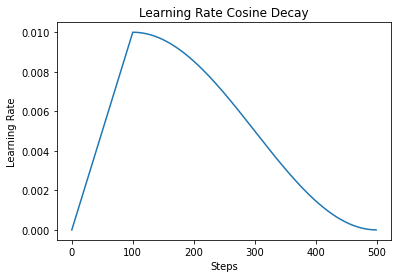

In [25]:
TOTAL_STEPS = 500    # total training steps 
BASE_LR= 0.01         # Base learning rate 
WARMUP_STEPS = 100     # Warmup steps for learning_rate_scheduler
GRAD_NORM_CLIP = 1    # Glips gradient norm 
ACCUM_STEPS = 8       # Controls in how many forward passes the batch is split (8 for TPU)
VERBOSE = 50          # Verbosity

lr_function = learning_rate_scheduler(base_learning_rate = BASE_LR,         
                                      total_steps = TOTAL_STEPS,
                                      warmup_steps = WARMUP_STEPS)
                                #check utlilty function for details 
plot_lr = []
for step in range(TOTAL_STEPS):
    plot_lr.append(lr_function(step).item())
plt.plot(plot_lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Cosine Decay");

## <span style="color:#e76f51;">Training : </span>

In [26]:
 # Update step for data parallel training
update_fn_repl = train.make_update_fn(apply_fn=model.apply,                
                                      accum_steps= ACCUM_STEPS , 
                                      lr_fn=lr_function)

# Momentum optimizer that stores state using half-precision
opt = momentum_clip.Optimizer(grad_norm_clip=GRAD_NORM_CLIP).create(params) 

# Replicating optimizer across devices
opt_repl = flax.jax_utils.replicate(opt) 

# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(SEED))       

* I have implemented a custom train function for ease and simplicity.
* The function provides an option to get the best parameter based on the minimum training loss.
* Verbosity can also be set manually.
* Option to plot `loss vs steps graph` at the end of training.
* See the docstring for more details

In [27]:
def train(opt_repl,
          update_rng_repl, 
          total_steps, 
          data, 
          save_best_parameters=True, 
          verbose = 0 , 
          plot_loss_graph = True ):
    """
    Returns paramters after training
    Args:
    opt_repl : Optimier replicated across devices (8 devices for TPU).
    update_rng_rel : PRGs for dropout.
    total_steps : Int, Total training steps.
    data : Data for training.
    save_best_parameters : Bool, saves best parameters based on decreasing loss.
    verbose : Int, Verbosity of training 
    plot_loss_graph : Bool, plots loss vs steps graph at the end of training.
    """

    if save_best_parameters:
        best_loss = float('inf')
        best_opt = 0 
        
    for step, batch in zip(trange(1, total_steps + 1), data.as_numpy_iterator()):
        opt_repl, loss_repl, update_rng_repl = update_fn_repl(
            opt_repl, 
            flax.jax_utils.replicate(step), 
            batch, 
            update_rng_repl
        )
        
        if save_best_parameters:
            best_opt , best_loss = save_best_params(
                current_opt = opt_repl,
                best_opt = best_opt ,
                current_loss = loss_repl[0],
                best_loss = best_loss
            )
            
        if verbose:
            if step%verbose == 0 or step == 1:
                if save_best_parameters:
                    print(f"STEP: {step},   LOSS: {loss_repl[0]:.2f},   MIN LOSS: {best_loss:.2f}")
                else : 
                    print(f"STEP: {step},   LOSS: {loss_repl[0]:.2f}")
                

    if plot_loss_graph:
        plt.plot(losses)
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        
    if save_best_parameters:
        return best_opt
    return opt_repl

In [ ]:
opt_repl = train(opt_repl = opt_repl ,
                 update_rng_repl = update_rng_repl,
                 total_steps = TOTAL_STEPS,
                 data = train_ds,
                 save_best_parameters=True, 
                 verbose = VERBOSE, 
                 plot_loss_graph = True
                )

  0%|          | 0/1 [00:00<?, ?it/s]

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Evaluating Predictions </span></center> 
<a id="9"></a>

In [ ]:
valid_acc_jnp, valid_preds_jnp, valid_true_jnp = evaluate(
    opt_repl.target,  
    valid_ds , 
    NUM_VALIDATION_IMAGES , 
    BATCH_SIZE
)

val_acc = valid_acc_jnp.item()*100
print(f"Validation Accuracy = {val_acc:.2f}%")

## <span style="color:#e76f51;">Confusion Matrix with various evaluation metrics : </span>

In [ ]:
y_true = valid_true_jnp.astype("int32")
y_preds = valid_preds_jnp.astype("int32")

labels = range(len(CLASSES))
cmat = confusion_matrix(y_true, y_preds, labels= labels)
score = f1_score(y_true, y_preds, labels=labels, average='macro')
precision = precision_score(y_true, y_preds, labels=labels, average='macro')
recall = recall_score(y_true, y_preds, labels=labels, average='macro')
display_confusion_matrix(cmat,score,precision,recall)

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Test Predictions and Submission  </span></center> 
<a id="10"></a>

## <span style="color:#e76f51;"> Making Predictions  : </span>

In [ ]:
test_preds = predictions(opt_repl.target, test_ds, NUM_TEST_IMAGES, BATCH_SIZE)

## <span style="color:#e76f51;"> Predictions to Submission: </span>

In [ ]:
test_preds = np.append(test_preds, np.ones(NUM_TEST_IMAGES%BATCH_SIZE)*stats.mode(test_preds)[0].item()).astype("int") #unbatched images are predicted as most common prediction

In [ ]:
submission = pd.DataFrame(
    data = np.array([test_ids, test_preds ]).T, 
    columns = ["id", "label"]
)
submission.to_csv("submission.csv", index = False)
submission.head()

## <span style="color:#e76f51;"> References  : </span>

https://www.kaggle.com/ryanholbrook/create-your-first-submission

https://www.kaggle.com/usharengaraju/devfest2020identifyingmelanomainlesionimages/

https://www.kaggle.com/frightera/tf-data-ensemble-transfer-learning-f1-0-95

https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb

https://github.com/google-research/vision_transformer

https://www.kaggle.com/jalammar/intro-to-data-input-pipelines-with-tf-data

   
    
### <center>Thank you for reading🙂</center><br>
### <center>If you have any feedback, please let me know!</center><br>
